In [ ]:
!pip install transformers sentence-transformers datasets rouge_score nltk

### Summarization

Ваше задание заполнить пропуски в функциях, улучшить качество модели за счёт более сложного алгоритма отбора предложений, в конце вызвать несколько abstractive summarization моделей и провести анализ результатов по метрикам ROUGE-1,2,L.

In [ ]:
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import datasets
data = datasets.load_dataset("multi_news")
train_dataset, val_dataset = data['train'], data['validation']

SEMINAR_MODE = True
if SEMINAR_MODE:
  val_dataset = [val_dataset[i] for i in range(0, len(val_dataset), 5)]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
example = val_dataset[42]
sources = tuple(filter(len, map(str.strip, example['document'].split('|||||'))))

for i, source in enumerate(sources):
    print(f"SOURCE #{i}: {source}\n{'=' * 50}\n")
print("SUMMARY:\n", example['summary'])

SOURCE #0: (KUTV) A Vernal man has been charged with raping a 9-year-old girl while police say the girl's mother was getting high on meth. 
 
 Police identified the suspect as Larson James RonDeau, 36. 
 
 According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home. 
 
 Police said the mother and her friend agreed to get high on meth and went into the garage area, where they were for around 30 minutes. 
 
 When the mother returned, her daughter's dress was "pulled up past her waist" and she "appeared to be upset", according to the statement. The mother said she then called for a cab and returned with her daughter to their own apartment. 
 
 When questioned by her mother, police say the girl told her "four meneach raped her." The PC statement describes in greater detail the alleged attack. One man, according to police, threatened to kill the li

In [ ]:
MAX_WORDS = 100

def summarize_baseline(doc: str, max_words=MAX_WORDS):
    sentences = nltk.sent_tokenize('\n'.join(doc.split('|||||')))
    summary = []
    num_words = 0

    for sent in sentences:
        sentence_length = len(nltk.word_tokenize(sent))
        if num_words + sentence_length > max_words:
            break
        num_words += sentence_length
        summary.append(sent)
    return ' '.join(summary)

In [ ]:
print(summarize_baseline(val_dataset[42]['document']))

(KUTV) A Vernal man has been charged with raping a 9-year-old girl while police say the girl's mother was getting high on meth. Police identified the suspect as Larson James RonDeau, 36. According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home.


### Замерим ROUGE

In [ ]:
from rouge_score import rouge_scorer
from tqdm.auto import trange


scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(target='The quick brown fox jumps over the lazy dog',
                      prediction='The quick brown dog jumps on the log.')
print(scores['rouge1'].fmeasure, scores['rougeL'].fmeasure)

0.7058823529411765 0.5882352941176471


In [ ]:
def compute_rouge_f1(dataset, predictions):

    ############# <YOUR CODE: compute mean f-measures for Rouge-1 and Rouge-L>

    rouge1 = []
    rougeL = []
    for i in range(0, len(dataset)):
        source = dataset[i]['summary']
        scores = scorer.score(target=source, prediction=predictions[i])
        rouge1.append(scores['rouge1'].fmeasure)
        rougeL.append(scores['rougeL'].fmeasure)
    return sum(rouge1)/len(rouge1), sum(rougeL)/len(rougeL)

In [ ]:
baseline_predictions = [summarize_baseline(row['document']) for row in val_dataset]
baseline_rouge1, baseline_rougeL = compute_rouge_f1(val_dataset, baseline_predictions)

print("Rouge-1:", baseline_rouge1)
print("Rouge-L:", baseline_rougeL)

if SEMINAR_MODE:
    assert abs(baseline_rouge1 - 0.26632) < 1e-3 and abs(baseline_rougeL - 0.14617) < 1e-3
    print("Well done!")

Rouge-1: 0.2668067854981659
Rouge-L: 0.1465153793717691
Well done!


### Neural extractive summarization

![](https://i.imgur.com/kkrzeq7.png)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, max_features=50_000)
vectorizer.fit([item['document'] for item in train_dataset])
encode_func = lambda texts: vectorizer.transform(texts).toarray()

In [ ]:
len(val_dataset)

1125

In [ ]:
doc = val_dataset[42]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

Sentence embeddings shape: (72, 50000)
Document embedding shape: (4, 50000)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarities between each pair of sentences
sentence_similarities = cosine_similarity(sentence_embeddings, sentence_embeddings)

# ... and also between each sentence and each document
document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)

assert sentence_similarities.shape == (len(sentences), len(sentences))
assert document_similarities.shape == (len(sentences), len(documents))

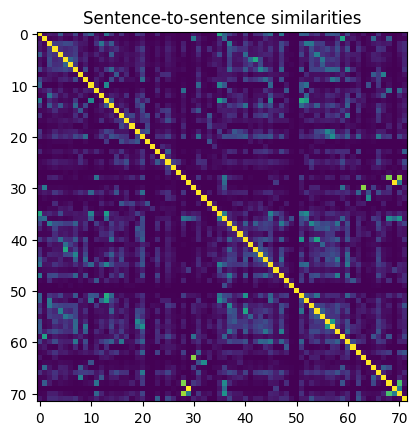

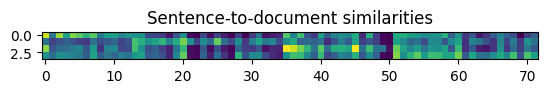

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()

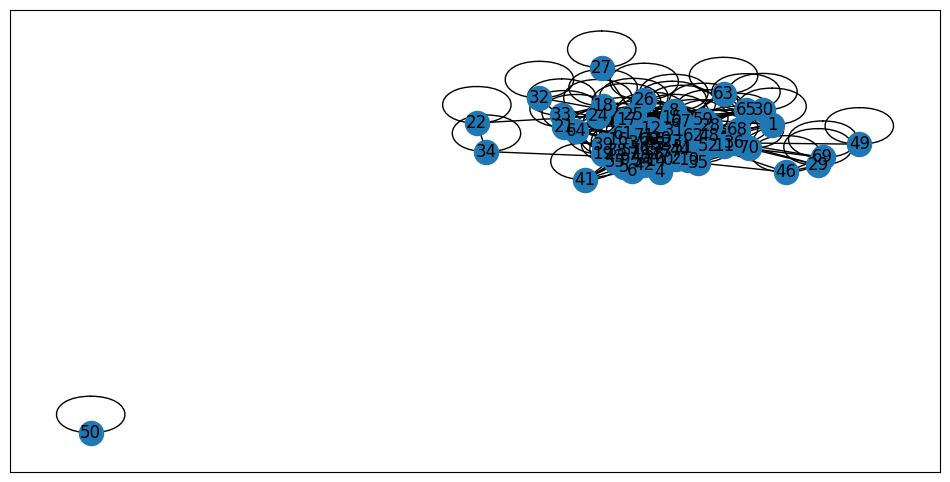

In [ ]:
import networkx

plt.figure(figsize=(12, 6))
networkx.draw_networkx(networkx.from_numpy_array(sentence_similarities > 0.1))

In [ ]:
def choose_summary_greedy(sentences, sentence_scores, sentence_similarities, sentence_lengths,
                          max_words=MAX_WORDS, sim_threshold=0.9):
    assert sentence_scores.shape == (len(sentences),)
    chosen_sentences = []
    max_similarities = np.zeros(len(sentences))
    num_words = 0

    for i in range(len(sentences)):
        mask = (sentence_lengths <= (max_words - num_words)) & (max_similarities < sim_threshold)
        if not np.any(mask):
            break

        best_sentence_index = np.argmax(sentence_scores * mask)

        chosen_sentences.append(sentences[best_sentence_index])


        max_similarities = np.maximum(max_similarities, sentence_similarities[best_sentence_index])
        num_words += sentence_lengths[best_sentence_index]

    return chosen_sentences



In [ ]:
sentence_scores = sentence_similarities.mean(axis=-1)

summary_sentences = choose_summary_greedy(
    sentences, sentence_scores, sentence_similarities, sentence_lengths,
    max_words=MAX_WORDS, sim_threshold=1.0)
print(summary_sentences)

['One of the men allegedly told the girl he would kill her if she ever reported the incident, and the threat was made during the alleged rape.', "Related story: Grandmother of 9-year-old Utah girl allegedly raped by four men: ‘I want justice’ \n \n RonDeau told police that the other three men had traveled to Montana for personal business along with the woman who the girl's mother had been there to visit, Glynda RonDeau.", 'When questioned by her mother, police say the girl told her "four meneach raped her."']


In [ ]:
sentence_similarities.shape

(72, 72)

### Putting it all together

In [ ]:
import numpy as np

# - mean similarity to 3 nearest sentences
def average_neighbor(row, col):
    rows, cols = sentence_similarities.shape
    neighbors = sentence_similarities[max(0, row-1):min(rows, row+2), max(0, col-1):min(cols, col+2)]
    return np.mean(neighbors)

def summarize_one(document, max_words=MAX_WORDS, sim_threshold=0.5):
    if document == '':
      return ''
    documents = tuple(filter(len, map(str.strip, document.split('|||||'))))

    sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
    sentences = [sent for document in sentences_by_doc for sent in document]
    sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

    # use encode_func to compute embedding matrices
    sentence_embeddings = encode_func(sentences)
    document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))

    # compute pairwise similarities between sentences and sentence-document pairs
    sentence_similarities = cosine_similarity(sentence_embeddings, sentence_embeddings)
    document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)


    # Compute the scores s.t. higher score corresponds to better sentences.
    # There are many ways to devise such a function, try them for yourself and see which works best.
    # Here's a few inspirations:
    # - mean similarity to 3 nearest sentences [please start with this one]
    # - page-rank scores that use similarity matrix as connectivity matrix
    # - distance to the nearest cluster in embedding space using k-means clustering


    vectorized_avg_neighbor = np.vectorize(average_neighbor)

    sentence_scores = vectorized_avg_neighbor(np.arange(sentence_similarities.shape[0]), np.arange(sentence_similarities.shape[1]))

    #sentence_scores = sentence_similarities.mean(axis=-1)

    ######## Change for more interesting algo and results
    ######## [make dep inj or clone function to preserve results for comparison]
    summary_sentences = choose_summary_greedy(
        sentences, sentence_scores, sentence_similarities, sentence_lengths,
        max_words=max_words, sim_threshold=sim_threshold)

    return '\n'.join(summary_sentences)

In [ ]:
print(summarize_one(val_dataset[2]['document']))

DeShazo and Bigler's work is published in the American Journal of Medicine.
A sample size of two nuggets is simply too small to generalize to an entire category of food, she told Reuters Health.
"We've taken a very healthy product—lean, white meat—and processed it, goo-ed it up with fat, sugar, and salt [in the breading]," he said.
That was 58 percent fat, 24 percent carbs, and 18 percent protein.
In some fast-food restaurants."
So do non-kids.


In [ ]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in average_neighbor (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in average_neighbor (vectorized)
  outputs = ufunc(*inputs)
/u

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

Rouge-1: 0.2458995890245506
Rouge-L: 0.140225729197043


### Can we do better than TF-IDF?

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE').train(False)

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [ ]:
emb1, emb2, emb3, emb4 = model.encode(
    ['Hello, world!', 'Greeting, universe!', 'Hello, John!', "A cat sat on the mat."]
)

In [ ]:
print("Sim(hello world, hello john) =", emb1 @ emb3)
print("Sim(hello world, greetings universe) =", emb1 @ emb2)
print("Sim(hello world, a cat sat on the mat)=", emb1 @ emb4)

Sim(hello world, hello john) = 0.7253735
Sim(hello world, greetings universe) = 0.79097307
Sim(hello world, a cat sat on the mat)= 0.16163


In [ ]:
encode_func = model.encode

Sentence embeddings shape: (32, 768)
Document embedding shape: (2, 768)


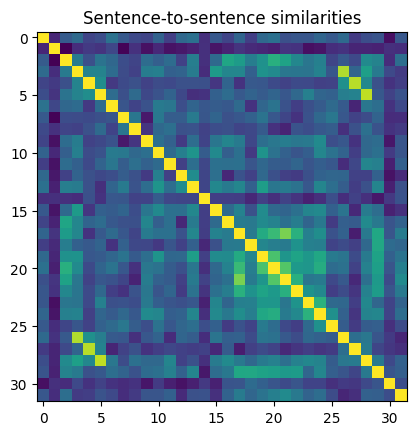

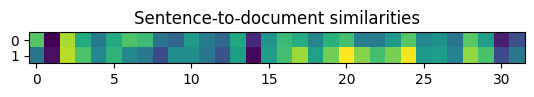

In [ ]:
doc = val_dataset[50]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

sentence_similarities = sentence_embeddings @ sentence_embeddings.T
document_similarities = sentence_embeddings @ document_embeddings.T

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()


Долго считает ответы, не успевает доработать до конца - дедлайн)
Проверю на маленьком кусочке

In [ ]:
our_summaries = []
val_dataset_ = val_dataset[:50]
for i in trange(len(val_dataset_)):
    our_summaries.append(summarize_one(val_dataset_[i]['document']))

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/cor

In [ ]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset_, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

Rouge-1: 0.16009243623236585
Rouge-L: 0.10873484137588624


### Call the cavalry!

[Pegasus](https://arxiv.org/abs/1912.08777) is an *abstractive* summarization model based on a large pre-trained transformer. Before doing any summarizaton, the model is pre-trained on a combination of MLM and a specialized objective called Gap Sentence Generation: predicting an entire sentence omitted from the middle of the text.

Compare with our models and gensim

In [ ]:
import transformers
pegasus = transformers.pipeline("summarization", "google/pegasus-multi_news")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-multi_news and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
print(example['document'])

(KUTV) A Vernal man has been charged with raping a 9-year-old girl while police say the girl's mother was getting high on meth. 
 
 Police identified the suspect as Larson James RonDeau, 36. 
 
 According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home. 
 
 Police said the mother and her friend agreed to get high on meth and went into the garage area, where they were for around 30 minutes. 
 
 When the mother returned, her daughter's dress was "pulled up past her waist" and she "appeared to be upset", according to the statement. The mother said she then called for a cab and returned with her daughter to their own apartment. 
 
 When questioned by her mother, police say the girl told her "four meneach raped her." The PC statement describes in greater detail the alleged attack. One man, according to police, threatened to kill the little girl i

In [ ]:
document = example['document'].split('|||||')[0]
print("SUMMARY:", pegasus([document], min_length=5, max_length=100)[0]['summary_text'])

SUMMARY: – A Vernal, Utah, man has been charged with raping a 9-year-old girl while her mother was high on meth, KUTV reports. According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home. Police said the mother and her friend agreed to get high on meth and went into the garage area, where they were for around 30 minutes
